In [6]:
# Import necessary libraries and dataset
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))
from src.data_generator import (
    generate_base_dataset,
    add_noise_to_target,
    add_multicollinearity,
    downsample_dataset
)

In [7]:
# Generate base dataset
X_base, y_base = generate_base_dataset()

In [8]:
# Create dataset variants
y_noisy =add_noise_to_target(y_base, noise_level=20)
X_corr = add_multicollinearity(X_base, correlated_pairs=[(0, 1)])
X_small, y_small = downsample_dataset(X_base, y_base, n_samples=50)

In [ ]:
# PAckage for iterations
datasets = {
    "Base": (X_base, y_base),
    "Noisy": (X_base, y_noisy),
    "Multicollinear": (X_corr, y_base),
    "Small Samples": (X_small, y_small)
}

In [10]:
# Linear Regression across the four variants
results = []

for name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Dataset": name,
        "RMSE": rmse,
        "R2": r2
    })

In [11]:
# results to dataframe
results_df = pd.DataFrame(results)
print(results_df)

          Dataset          RMSE        R2
0            Base  2.990341e-13  1.000000
1           Noisy  1.992445e+01  0.984437
2  Multicollinear  7.309533e+01  0.786316
3   Small Samples  2.352530e-13  1.000000


### As expected Linear regression handles clean and small-sample datasets well, but fails under multicollinearity and is moderately sensitive to noise.

In [12]:
# Import libraries for polynomial 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [14]:
# Polynomial Regression (degree 2)
results_poly = []

for name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results_poly.append({
        "Dataset": name,
        "RMSE": rmse,
        "R²": r2
    })

In [15]:
# results to DataFrame
results_poly_df = pd.DataFrame(results_poly)
print(results_poly_df)

          Dataset          RMSE        R²
0            Base  5.934794e-13  1.000000
1           Noisy  2.056049e+01  0.983428
2  Multicollinear  7.665643e+01  0.764988
3   Small Samples  1.896896e-13  1.000000


Adding polynomial complexity slightly improves fit on simple data but exacerbates multicollinearity problems, highlighting the need for regularization

In [16]:
# Libraries Ridge Regression
from sklearn.linear_model import Ridge


In [17]:
# Ridge Regression
results_ridge = []

for name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results_ridge.append({
        "Dataset": name,
        "RMSE": rmse,
        "R²": r2
    })

In [18]:
# Convert results to DataFrame
results_ridge_df = pd.DataFrame(results_ridge)
print(results_ridge_df)

          Dataset       RMSE        R²
0            Base   0.429342  0.999993
1           Noisy  19.985381  0.984342
2  Multicollinear  73.571540  0.783522
3   Small Samples   4.515423  0.998510


Ridge helps slightly with multicollinearity but requires tuning; otherwise, it performs almost identical to Linear on clean or small datasets

In [19]:
# Now for lasso
from sklearn.linear_model import Lasso

In [20]:
# Lasso Regression
results_lasso = []

for name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = Lasso(alpha=0.1, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results_lasso.append({
        "Dataset": name,
        "RMSE": rmse,
        "R²": r2
    })


In [22]:
# results to DataFrame
results_lasso_df = pd.DataFrame(results_lasso)
print(results_lasso_df)

          Dataset       RMSE        R²
0            Base   0.228829  0.999998
1           Noisy  19.948556  0.984400
2  Multicollinear  73.533970  0.783743
3   Small Samples   0.270098  0.999995


Lasso shrinks coefficients and can promote sparsity, but with mild alpha it behaves similarly to Ridge. Multicollinearity is slightly mitigated, but strong collinearity still hurts performance.

In [23]:
# Visualize results 
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Combine all results into one DataFrame
results_df_all = pd.concat([
    results_df.assign(Model='Linear'),
    results_poly_df.assign(Model='Polynomial'),
    results_ridge_df.assign(Model='Ridge'),
    results_lasso_df.assign(Model='Lasso')
])

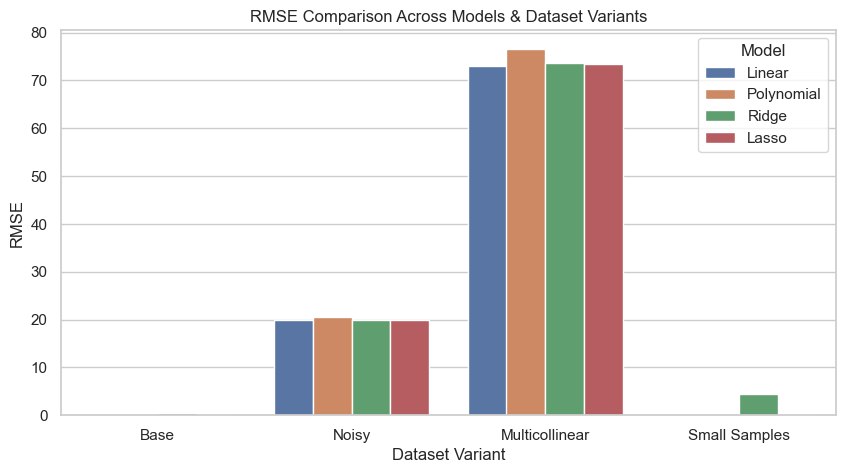

In [25]:
# Set seaborn style
sns.set(style="whitegrid")

# Plot RMSE
plt.figure(figsize=(10,5))
sns.barplot(data=results_df_all, x='Dataset', y='RMSE', hue='Model')
plt.title("RMSE Comparison Across Models & Dataset Variants")
plt.ylabel("RMSE")
plt.xlabel("Dataset Variant")
plt.legend(title='Model')
plt.show()

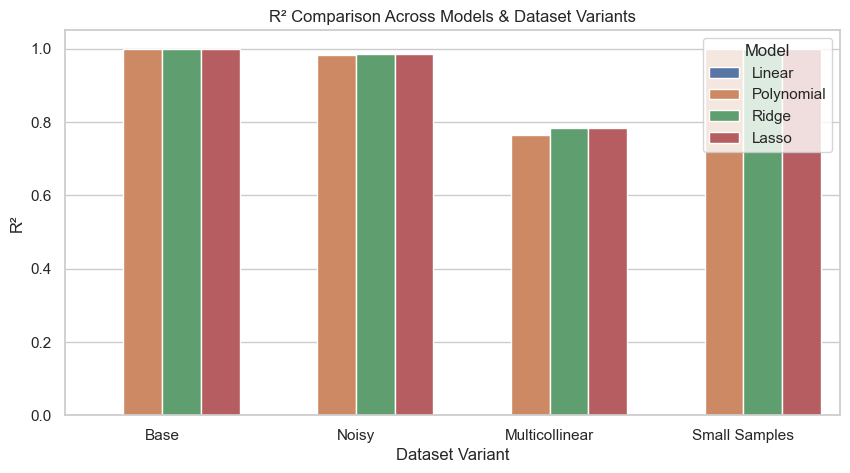

In [27]:
# Plot R²
plt.figure(figsize=(10,5))
results_df_all_reset = results_df_all.reset_index(drop=True)
sns.barplot(data=results_df_all_reset, x='Dataset', y='R²', hue='Model')
plt.title("R² Comparison Across Models & Dataset Variants")
plt.ylabel("R²")
plt.xlabel("Dataset Variant")
plt.ylim(0,1.05)
plt.legend(title='Model')
plt.show()

# Experiment Setup
We generate 4 dataset variants to simulate real-world challenges for regression models:
- Base (clean)
- Noisy
- Multicollinear
- Small Samples


Future work could include:
- ElasticNet regression for hybrid regularization
- Applying the experiment to real-world datasets
- Adding automated feature importance analysis


### Real-World Validation: California Housing Dataset

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import fetch_california_housing


In [3]:
# Load the california dataset housing dataset
data = fetch_california_housing(as_frame=True)
df = data.frame